多因子期货

分钟线预测涨跌

In [1]:
import os
import sys
import glob
import pathlib
from copy import deepcopy
from itertools import combinations
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import talib
from sklearn import preprocessing

In [2]:

import akshare as ak

In [2]:
""" 候选品种
TA0 czce    PTA连续
MA0	czce	甲醇连续
RM0	czce	菜粕连续
C0  dce     玉米连续
"""

ta_df = ak.futures_zh_minute_sina(symbol="TA2301", period="5")
print(ta_df.shape)
ta_df.head()

(1023, 7)


,datetime,open,high,low,close,volume,hold
0,2022-09-16 22:05:00,5676.0,5686.0,5670.0,5672.0,25249,1246923
1,2022-09-16 22:10:00,5672.0,5694.0,5672.0,5688.0,24593,1246534
2,2022-09-16 22:15:00,5690.0,5714.0,5686.0,5708.0,49739,1245950
3,2022-09-16 22:20:00,5706.0,5718.0,5702.0,5718.0,37575,1251367
4,2022-09-16 22:25:00,5716.0,5728.0,5710.0,5722.0,48409,1254110


In [3]:
ta_df.tail()

,datetime,open,high,low,close,volume,hold
1018,2022-10-14 22:40:00,5412.0,5416.0,5410.0,5412.0,13793,1125346
1019,2022-10-14 22:45:00,5412.0,5418.0,5408.0,5408.0,19782,1125544
1020,2022-10-14 22:50:00,5408.0,5412.0,5400.0,5406.0,19553,1125056
1021,2022-10-14 22:55:00,5406.0,5412.0,5402.0,5406.0,14768,1124061
1022,2022-10-14 23:00:00,5404.0,5406.0,5386.0,5392.0,29639,1109585


In [4]:
from collections import Counter
Counter((pd.to_datetime(ta_df["datetime"]) > pd.to_datetime("2022-09-20")) == True)

Counter({False: 81, True: 942})

## feature

In [2]:
FUTURE = 10
TASK = "clf"

In [127]:
def get_ma_feature(df):
    periods = np.arange(3,30)
    for i in periods:
        # df[f"ma{i}"] = talib.SMA(df["close"], timeperiod=i)
        ma = talib.EMA(df["close"], timeperiod=i)
        # df[f"kama{i}"] = talib.KAMA(df["close"], timeperiod=i)
        # df[f"open_ma{i}"] = talib.EMA(df["open"], timeperiod=i)
        df[f"ma{i}_close"] = ma - df["close"]
        
    # combines = combinations(periods, 2)
    # for i in combines:
    #     if i[0] < i[1]:
    #         df[f"ma{i[0]}-{i[1]}"] = df[f"ma{i[0]}"] - df[f"ma{i[1]}"]
            
    # combines = combinations(periods, 3)
    # for i in combines:
    #     if i[0] < i[1] < i[2]:
    #         df[f"ma{i[0]}-{i[1]}-{i[2]}"] = df[f"ma{i[0]}"] - df[f"ma{i[1]}"]- df[f"ma{i[2]}"]

def get_add_feature(df):
    low, high, close = df["low"], df["high"], df["close"]

    # Support and resistance
    periods = np.arange(3,30)
    for i in periods:
        df[f"support_{i}"] = df["close"].rolling(window=i).min() - df["close"]
        df[f"resistance_{i}"] = df["close"].rolling(window=i).max() - df["close"]
        df[f"shock_{i}"] = df["close"].rolling(window=i).std() - df["close"]
        
        df[f"up_count_{i}"] = (df["close"] - df["close"].shift(1)).apply(lambda x:1 if x>0 else 0)\
        .rolling(window=i).apply(lambda x:Counter(x)[1]) / i
        
        df[f"momentum_{i}"] = df["close"] / df["close"].shift(i) - 1
        

def get_momentum_feature(df):
    low, high, close = df["low"], df["high"], df["close"]
    
    # ADX
    adx = talib.ADX(high, low, close, timeperiod=5)
    adx2 = talib.ADX(high, low, close, timeperiod=14)
    df["adx"] = adx
    df["adx2"] = adx2
    
    # AROON
    aroondown, aroonup = talib.AROON(high, low, timeperiod=14)
    df["aroondown"], df["aroonup"] = aroondown, aroonup
    
    # CCI
    cci = talib.CCI(high, low, close, timeperiod=7)
    cci2 = talib.CCI(high, low, close, timeperiod=14)
    df["cci"] = cci
    df["cci2"] = cci2
    
    # MACD
    macd, macdsignal, macdhist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    df["macd"], df["macdsignal"], df["macdhist"] = macd, macdsignal, macdhist
    
    # MOM
    mom = talib.MOM(close, timeperiod=5)
    mom2 = talib.MOM(close, timeperiod=10)
    df["mom"] = mom
    df["mom"] = mom2
    
    # ROC
    roc = talib.ROC(close, timeperiod=5)    
    roc2 = talib.ROC(close, timeperiod=10)
    df["roc"] = roc
    df["roc2"] = roc2
    
    # RSI
    rsi = talib.RSI(close, timeperiod=7)
    rsi2 = talib.RSI(close, timeperiod=14)
    df["rsi"] = rsi
    df["rsi2"] = rsi2
    
    # KD
    slowk, slowd = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df["slowk"], df["slowd"] = slowk, slowd
    
    # WILLR
    willr = talib.WILLR(high, low, close, timeperiod=7)
    willr2 = talib.WILLR(high, low, close, timeperiod=14)
    df["willr"] = willr
    df["willr2"] = willr2


def get_volume_feature(df):
    low, high, close, volume = df["low"], df["high"], df["close"], df["volume"]
    
    # AD
    ad = talib.AD(high, low, close, volume)
    df["ad"] = ad
    
    # ADOSC
    adsoc = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df["adsoc"] = adsoc
    
    # OBV
    obv = talib.OBV(close, volume)
    df["obv"] = obv


def get_volatility_feature(df):
    low, high, close = df["low"], df["high"], df["close"]
    
    # ATR
    atr = talib.ATR(high, low, close, timeperiod=14)
    df["atr"] = atr
    
    # TRANGE
    trange = talib.TRANGE(high, low, close)
    df["trange"] = trange


def get_close_change(df, base="close"):
    # close change, use for label
    gap = FUTURE
    base_change = df.loc[gap:,base].values / df.loc[:(df.shape[0]-1-gap),base].values - 1
    base_change_rate = base_change * 100
    return np.hstack([base_change_rate,[0]*gap])

def get_label(close, avg_close, std_close):
    if (avg_close > close+0.1*std_close):
        return 1
    elif (avg_close < close-std_close):
        return 0
    else:
        return 0

def get_feature_df(df):
    df = deepcopy(df)
    
    # close_change = get_close_change(df, base="close")
    # close_open_rate = (df["close"] - df["open"]) / df["open"] * 100
        
    assert TASK in ("clf","reg")
    # calculate up/down
    if TASK=="clf":
        # labels = []
        # for cc,co in zip(np.hstack([close_change[1:], [0]]),
        #                  np.hstack([close_open_rate[1:], [0]])):
        #     if cc > 0 and co > 0:
        #         label = 1 # buy
        #     elif cc < 0 and co < 0:
        #         label = 0 # short
        #     else:
        #         label = 2 # no change
        #     labels.append(label)
        # df["label"] = np.array(labels)
        # labels = close_change
        # df["label"] = np.array(list(map(lambda x:1 if x>0 else 0, labels)))
        window = FUTURE
        avg_close = df["close"].rolling(window=window).mean().shift(-window)
        # std_close = df["close"].rolling(window=window).std().shift(window)
        # future_df = pd.concat([df["close"], avg_close, std_close], axis=1)
        # future_df.columns = ["close","avg_close","std_close"]
        # df["label"] = future_df.apply(lambda x: get_label(x.close,x.avg_close,x.std_close), axis=1)
        df["label"] = (avg_close - df["close"]).apply(lambda x: 1 if x>0 else 0)
    if TASK=="reg":
        df["label"] = close_change
    
    # calculate factor
    # get_ma_feature(df)
    # get_add_feature(df)
    get_momentum_feature(df)
    # get_volume_feature(df)
    # get_volatility_feature(df)
    
    # drop anomaly value
    df = df.dropna().reset_index(drop=True)
    df = df.drop(0, axis=0).reset_index(drop=True)
    df = df.drop([len(df)-1], axis=0).reset_index(drop=True)
    return df

def get_feature_label(df):
    feature_df = df.drop(["date","open","high","low","close","volume","label"],axis=1)
    # feature_df = (feature_df-feature_df.min())/(feature_df.max()-feature_df.min())
    # feature_df = (feature_df-feature_df.mean())/(feature_df.std())
    features = feature_df.values
    labels = df["label"].values
    return features, labels

In [66]:
get_feature_df(ta_df).head(10)

NameError: name 'ta_df' is not defined

## analyse

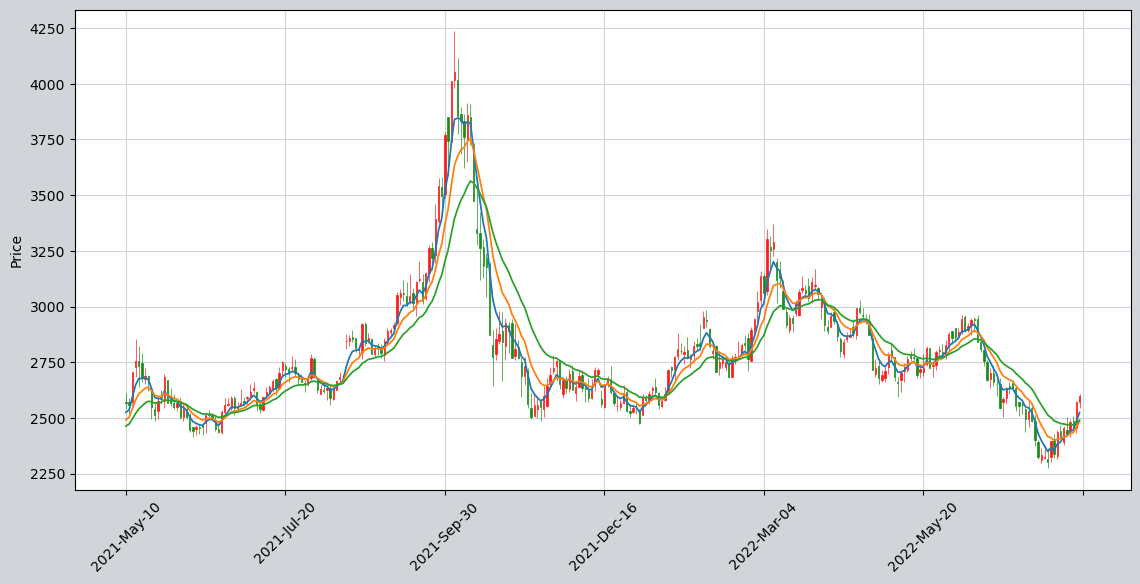

In [132]:
"""
https://blog.csdn.net/Shepherdppz/article/details/117575286
"""
import mplfinance as mpf
def plot_candle(df):
    df = deepcopy(df)
    # 设置mplfinance的蜡烛颜色，up为阳线颜色，down为阴线颜色
    my_color = mpf.make_marketcolors(up='r',
                                     down='g',
                                     edge='inherit',
                                     wick='inherit',
                                     volume='inherit')
    # 设置图表的背景色
    my_style = mpf.make_mpf_style(marketcolors=my_color,
                                  figcolor='(0.82, 0.83, 0.85)',
                                  gridcolor='(0.82, 0.83, 0.85)')


    fig = mpf.figure(style=my_style, figsize=(12, 8), facecolor=(0.82, 0.83, 0.85))
    # 添加三个图表，四个数字分别代表图表左下角在figure中的坐标，以及图表的宽（0.88）、高（0.60）
    ax1 = fig.add_axes([0.06, 0.25, 0.88, 0.60])

    # 读取的测试数据索引为字符串类型，需要转化为时间日期类型
    df.index = pd.to_datetime(df.datetime)

    # 通过ax=ax1参数指定把新的线条添加到ax1中，与K线图重叠
    ap = mpf.make_addplot(df[['ma5', 'ma10', 'ma20']], ax=ax1)
    
    # 调用plot()方法，注意传递addplot=ap参数，以添加均线
    mpf.plot(df,
             ax=ax1,
             addplot=ap,
             type='candle',
             style=my_style)

    fig.show()	
    
analyse = get_feature_df(dfs["MA0.czce"])
plot_candle(analyse.iloc[-300:])

## classification

In [118]:
FUTURE = 20
TASK = "clf"

In [119]:
train_X, train_Y, valid_X, valid_Y, test_X, test_Y = [],[],[],[],[],[]

df = ak.fund_etf_hist_sina(symbol="sh588000")
# df = pd.concat([ta_df], axis=0)
# df = pd.concat([dfs["TA0.czce"],dfs["CF0.czce"], dfs["OI0.czce"], dfs["B0.dce"], dfs["P0.dce"],
#                 dfs["V0.dce"], dfs["Y0.dce"], dfs["AL0.shfe"], dfs["RB0.shfe"], dfs["WR0.shfe"]], axis=0)
# df = pd.concat([dfs[key] for key in dfs.keys()], axis=0)

# df["datetime"] = pd.to_datetime(ta_df["datetime"])
train_df = df.iloc[:int(df.shape[0] * 0.8),:].reset_index(drop=True)
valid_df = df.iloc[int(df.shape[0] * 0.2):,:].reset_index(drop=True)

train_data = get_feature_label(get_feature_df(train_df).sample(frac=1))
valid_data = get_feature_label(get_feature_df(valid_df).sample(frac=1))

print(len(train_data[0]), len(valid_data[0]), train_data[0].shape)

341 342 (341, 135)


### fit

In [120]:
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix, accuracy_score

In [121]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(train_data[0], train_data[1])
# clf.predict(valid_data[0]), valid_data[1]

y_true, y_pred = train_data[1], clf.predict(train_data[0])
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))
accuracy_score(clf.predict(train_data[0]), train_data[1])

[[162  42]
 [ 69  68]]
              precision    recall  f1-score   support

           0       0.70      0.79      0.74       204
           1       0.62      0.50      0.55       137

    accuracy                           0.67       341
   macro avg       0.66      0.65      0.65       341
weighted avg       0.67      0.67      0.67       341



0.6744868035190615

In [122]:
y_true, y_pred = valid_data[1], clf.predict(valid_data[0])
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))
accuracy_score(clf.predict(valid_data[0]), valid_data[1])

[[182  27]
 [ 69  64]]
              precision    recall  f1-score   support

           0       0.73      0.87      0.79       209
           1       0.70      0.48      0.57       133

    accuracy                           0.72       342
   macro avg       0.71      0.68      0.68       342
weighted avg       0.72      0.72      0.71       342



0.7192982456140351

In [123]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100,max_depth=2, random_state=0)
clf.fit(train_data[0], train_data[1])

y_true, y_pred = train_data[1], clf.predict(train_data[0])
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))
accuracy_score(clf.predict(train_data[0]), train_data[1])


[[180  24]
 [ 41  96]]
              precision    recall  f1-score   support

           0       0.81      0.88      0.85       204
           1       0.80      0.70      0.75       137

    accuracy                           0.81       341
   macro avg       0.81      0.79      0.80       341
weighted avg       0.81      0.81      0.81       341



0.8093841642228738

In [124]:
y_true, y_pred = valid_data[1], clf.predict(valid_data[0])
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))
accuracy_score(clf.predict(valid_data[0]), valid_data[1])

[[202   7]
 [ 69  64]]
              precision    recall  f1-score   support

           0       0.75      0.97      0.84       209
           1       0.90      0.48      0.63       133

    accuracy                           0.78       342
   macro avg       0.82      0.72      0.73       342
weighted avg       0.81      0.78      0.76       342



0.7777777777777778

In [72]:
# import pickle
# with open("D:/quant/checkpoint/clf_ta_5min.pickle","wb") as f:
#     pickle.dump(clf, f)

In [74]:
valid_data[1]

array([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,

In [73]:
clf.predict_proba(valid_data[0])

array([[0.9766062 , 0.0233938 ],
       [0.06797032, 0.93202968],
       [0.9778686 , 0.0221314 ],
       [0.97947369, 0.02052631],
       [0.97947369, 0.02052631],
       [0.88539773, 0.11460227],
       [0.12225153, 0.87774847],
       [0.07181307, 0.92818693],
       [0.11233497, 0.88766503],
       [0.23302257, 0.76697743],
       [0.9778686 , 0.0221314 ],
       [0.06089119, 0.93910881],
       [0.97947369, 0.02052631],
       [0.97614036, 0.02385964],
       [0.05715911, 0.94284089],
       [0.97757679, 0.02242321],
       [0.9778686 , 0.0221314 ],
       [0.97947369, 0.02052631],
       [0.97947369, 0.02052631],
       [0.97947369, 0.02052631],
       [0.05700385, 0.94299615],
       [0.05705954, 0.94294046],
       [0.06968298, 0.93031702],
       [0.05958157, 0.94041843],
       [0.97947369, 0.02052631],
       [0.06039423, 0.93960577],
       [0.06054035, 0.93945965],
       [0.05449998, 0.94550002],
       [0.9766062 , 0.0233938 ],
       [0.85580393, 0.14419607],
       [0.

In [46]:
valid_data[1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

## regression

In [450]:
TASK = "reg"

In [451]:
train_X, train_Y, valid_X, valid_Y, test_X, test_Y = [],[],[],[],[],[]

df = dfs["MA0.czce"]
# df = get_feature_df(df)
train_df = df[df["datetime"] < '2021-07-01'].reset_index(drop=True)
valid_df = df[(df["datetime"] > "2021-07-01") & (df["datetime"] < "2022-01-01")].reset_index(drop=True)
test_df = df[df["datetime"] > "2022-01-01"].reset_index(drop=True)

train_data = get_feature_label(get_feature_df(train_df))
valid_data = get_feature_label(get_feature_df(valid_df))
test_data = get_feature_label(get_feature_df(test_df))

print(len(train_data[0]), len(valid_data[0]), len(test_data[0]), train_data[0].shape)

1544 89 104 (1544, 57)


In [452]:
from sklearn.metrics import mean_squared_error

In [453]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_data[0], train_data[1])
reg.predict(valid_data[0])
mean_squared_error(valid_data[1], reg.predict(valid_data[0]))

64.91751462398756

In [454]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(max_depth=6, random_state=0)
rf_reg.fit(train_data[0], train_data[1])
rf_reg.predict(valid_data[0])
mean_squared_error(valid_data[1], rf_reg.predict(valid_data[0]))

7.890115664766683

## plot

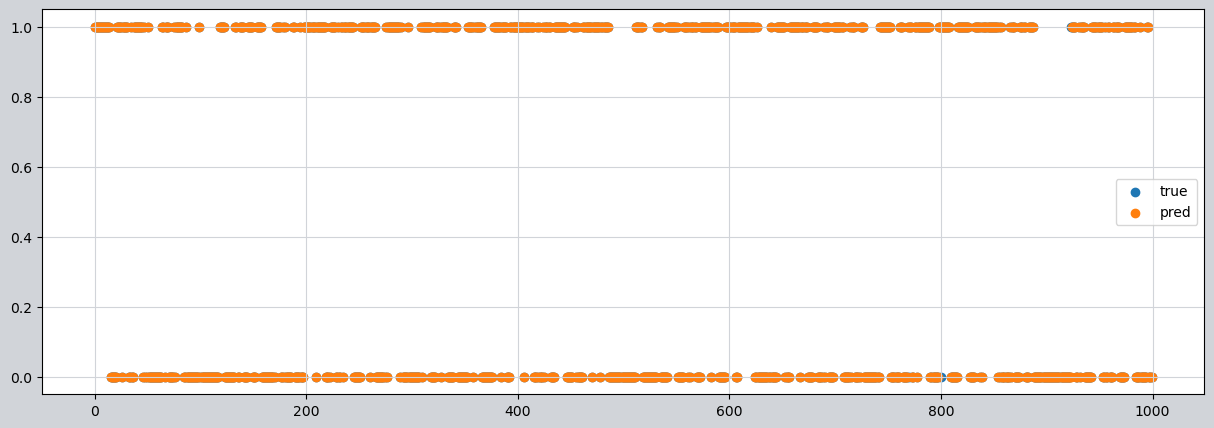

0.003


In [1057]:
import matplotlib.pyplot as plt

def evaluate(model, data, label):
    fig = plt.figure(figsize = (15,5))
    # plt.plot(label, label="true")
    plt.scatter(range(len(label)), label, label="true")
    preds = model.predict(data)
    # plt.plot(preds, label="pred")
    plt.scatter(range(len(preds)), preds, label="pred")
    plt.legend()
    plt.show()
    
    print(np.mean((preds - label)**2))

evaluate(clf, train_data[0][:1000], train_data[1][:1000])

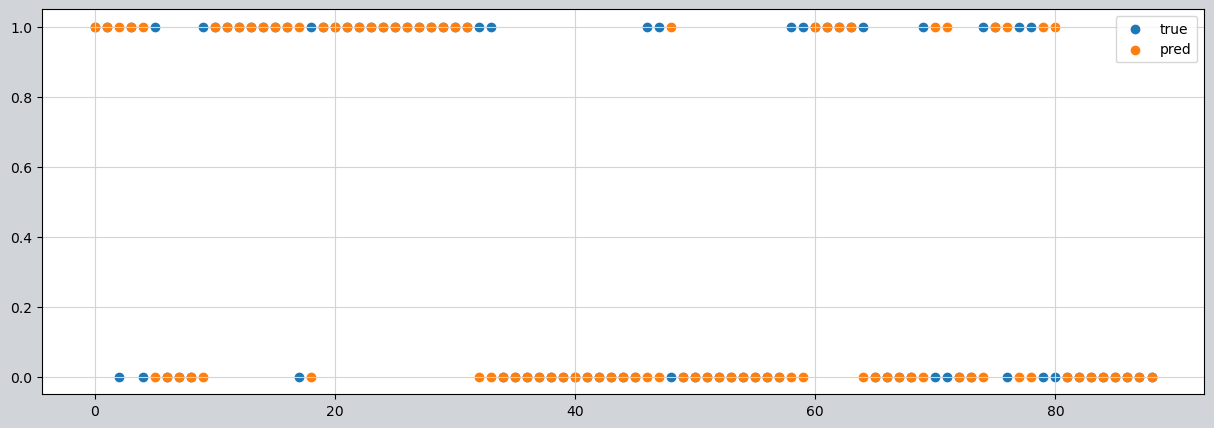

0.25842696629213485


In [1058]:
evaluate(clf, valid_data[0], valid_data[1])

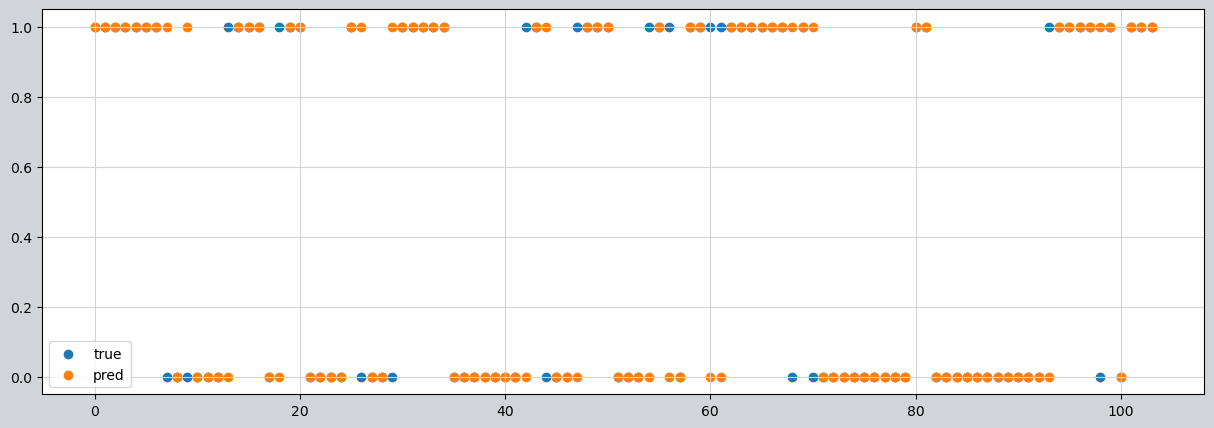

0.16346153846153846


In [1119]:
evaluate(clf, test_data[0], test_data[1])

## plot buy/sell

In [105]:
FUTURE

20

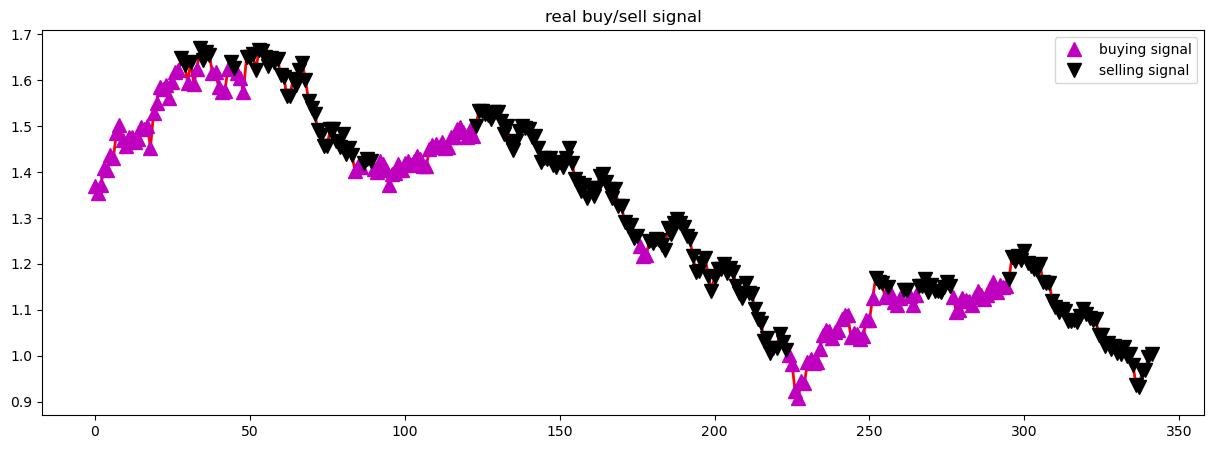

In [125]:
import matplotlib.pyplot as plt

# FUTURE = 20
analyse_df = get_feature_df(valid_df)

states_buy, states_sell = [],[]
for i in range(len(analyse_df)):
    if analyse_df.loc[i,"label"] == 1:
        states_buy.append(i)
    else:
        states_sell.append(i)
        
close = analyse_df['close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('real buy/sell signal')
plt.legend()
plt.show()

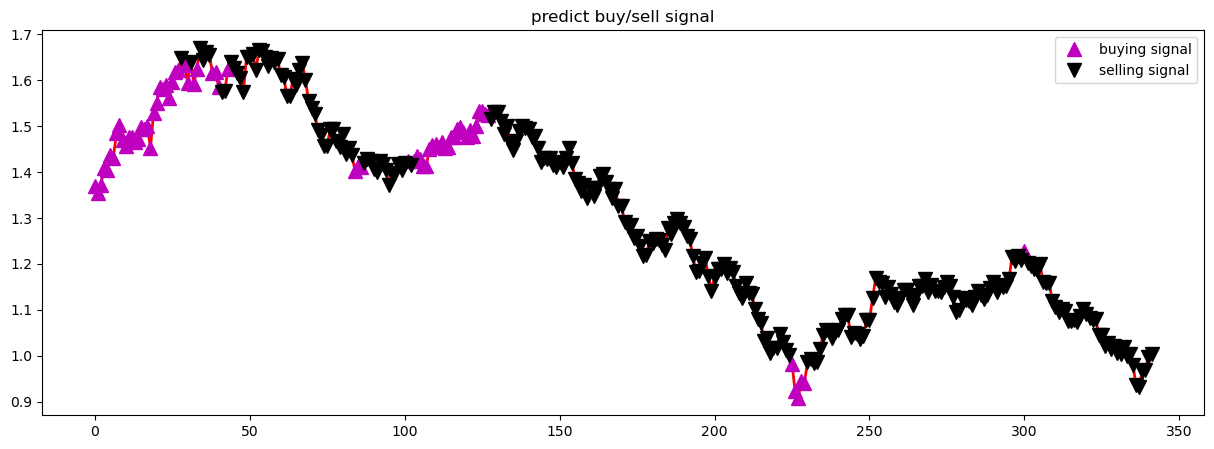

In [126]:
analyse_df = get_feature_df(valid_df)

features, labels = get_feature_label(analyse_df)
preds = clf.predict_proba(features)[:,1]

states_buy, states_sell = [],[]
for i in range(len(features)):
    if preds[i] > 0.5:
        states_buy.append(i)
    elif preds[i] < 0.5:
        states_sell.append(i)
        
close = analyse_df['close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('predict buy/sell signal')
plt.legend()
plt.show()

In [112]:
for col in analyse_df.columns[1:]:
    print(f"label -> {col}:", analyse_df.label.corr(analyse_df[col]))

label -> open: -0.2517573014704094
label -> high: -0.2520370539795085
label -> low: -0.24350035593784805
label -> close: -0.24856394258211545
label -> volume: -0.11098627364778779
label -> label: 1.0
label -> ma3: -0.26009271833889813
label -> ma3_close: -0.031065141098889006
label -> ma5: -0.24996488844589812
label -> ma5_close: 0.017378338659659435
label -> ma8: -0.220353288227354
label -> ma8_close: 0.08342037161146418
label -> ma10: -0.19536149629295718
label -> ma10_close: 0.12439686823937182
label -> ma15: -0.1834910919425158
label -> ma15_close: 0.12842030325292586
label -> ma20: -0.21810923041508368
label -> ma20_close: 0.06969088928716245
label -> ma3-5: -0.07807430082735245
label -> ma3-8: -0.13987696769731936
label -> ma3-10: -0.17854225943720348
label -> ma3-15: -0.16360067903605788
label -> ma3-20: -0.08947802929745072
label -> ma5-8: -0.16728893778560253
label -> ma5-10: -0.20543256686488504
label -> ma5-15: -0.1676068638880558
label -> ma5-20: -0.07894664310293001
label 